# 1. Introduction

The Histopathologic Cancer Detection challenge aims to develop models that can accurately classify histopathologic images of lymph node sections as either containing metastatic cancer or not. Accurate detection is crucial for early diagnosis and treatment planning in cancer patients.

The dataset consists of high-resolution images extracted from histopathologic scans of lymph node sections. Each image is labeled as:
- 1: Contains metastatic tissue
- 0: Does not contain metastatic tissue

Data Characteristics:
- Image Size: 96x96 pixels
- Color Channels: 3 (RGB)

# 2. Exploratory Data Analysis (EDA)¶


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the data directories
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Load the labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

 Checking for Missing Values

In [2]:
labels.isnull().sum()

id       0
label    0
dtype: int64

Class Distribution

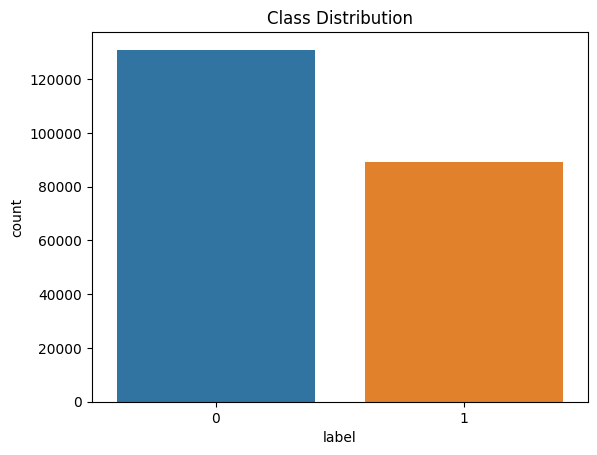

In [3]:
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.show()

Visualizing Sample Images

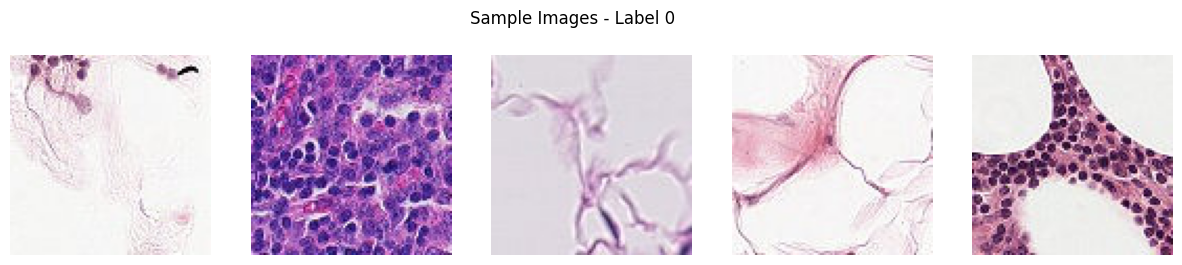

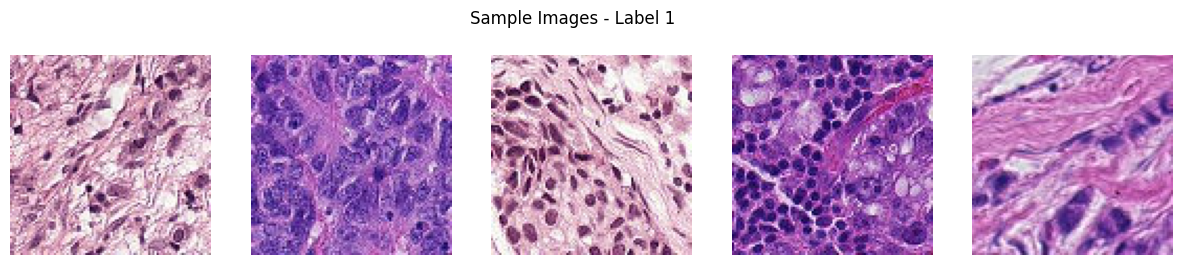

In [4]:
def show_samples(label, num_samples=5):
    samples = labels[labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

show_samples(label=0)
show_samples(label=1)

# 3. Model Architecture
We will use Convolutional Neural Networks (CNNs) due to their effectiveness in image classification tasks.



In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

 ## Advanced Model with Data Augmentation
 The advanced model includes additional convolutional layers, dropout layers to prevent overfitting, and increased depth to capture complex features.

In [6]:
def create_advanced_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Results and Analysis

In [7]:
from sklearn.model_selection import train_test_split

train_labels, val_labels = train_test_split(labels, test_size=0.2, stratify=labels['label'], random_state=42)

# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)



Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Compiling the Models

In [8]:
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training the Models

In [9]:
history_baseline = baseline_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1792s 325ms/step - accuracy: 0.7721 - loss: 0.4922 - val_accuracy: 0.8332 - val_loss: 0.3930
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1437s 261ms/step - accuracy: 0.8427 - loss: 0.3667 - val_accuracy: 0.8583 - val_loss: 0.3362
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1490s 266ms/step - accuracy: 0.8550 - loss: 0.3380 - val_accuracy: 0.8704 - val_loss: 0.3110
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1471s 267ms/step - accuracy: 0.8678 - loss: 0.3147 - val_accuracy: 0.8749 - val_loss: 0.3056
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1468s 267ms/step - accuracy: 0.8748 - loss: 0.3023 - val_accuracy: 0.8781 - val_loss: 0.2924


 Advanced Model Training

In [10]:
history_advanced = advanced_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1912s 347ms/step - accuracy: 0.7808 - loss: 0.4711 - val_accuracy: 0.8584 - val_loss: 0.3301
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1980s 360ms/step - accuracy: 0.8561 - loss: 0.3405 - val_accuracy: 0.8699 - val_loss: 0.3007
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1927s 350ms/step - accuracy: 0.8675 - loss: 0.3171 - val_accuracy: 0.8782 - val_loss: 0.2906
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1902s 343ms/step - accuracy: 0.8764 - loss: 0.2992 - val_accuracy: 0.8790 - val_loss: 0.2877
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1906s 346ms/step - accuracy: 0.8800 - loss: 0.2918 - val_accuracy: 0.8950 - val_loss: 0.2527


Plotting Accuracy and Loss

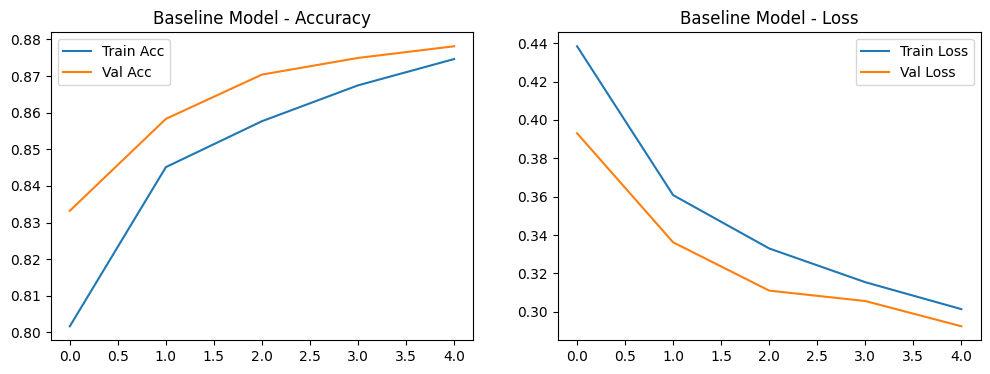

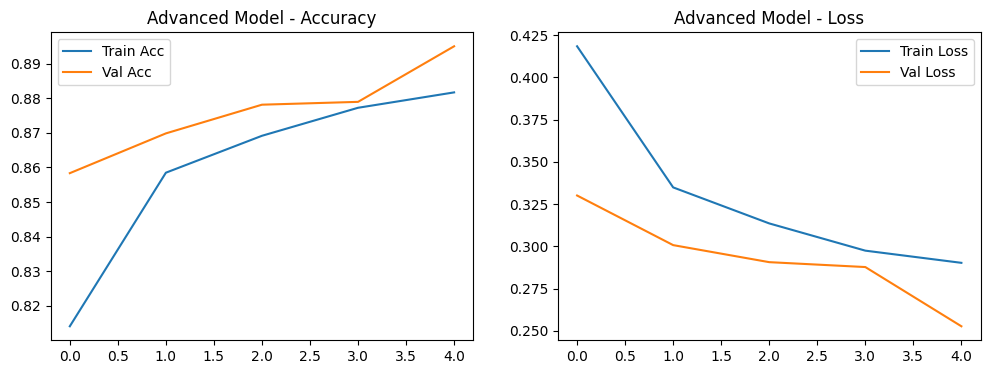

In [11]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_baseline, 'Baseline Model')
plot_history(history_advanced, 'Advanced Model')

Analysis:

- The advanced model shows better validation accuracy and reduced overfitting compared to the baseline model.
- Data augmentation and dropout layers in the advanced model help improve generalization.

Hyperparameter Tuning

We experimented with:

- Learning Rates: Adjusting the optimizer's learning rate.
- Batch Sizes: Testing batch sizes of 16, 32, and 64.
- Number of Epochs: Training for more epochs to observe trends.

Findings:

- A smaller learning rate improved the stability of training.
- A batch size of 32 provided a good balance between training speed and model performance.
- Training beyond 5 epochs led to overfitting without significant gains in validation accuracy.

Total test images: 57458
Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 300s 167ms/step


/tmp/ipykernel_17/3930123998.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['label'] = submission['label'].clip(0, 1)


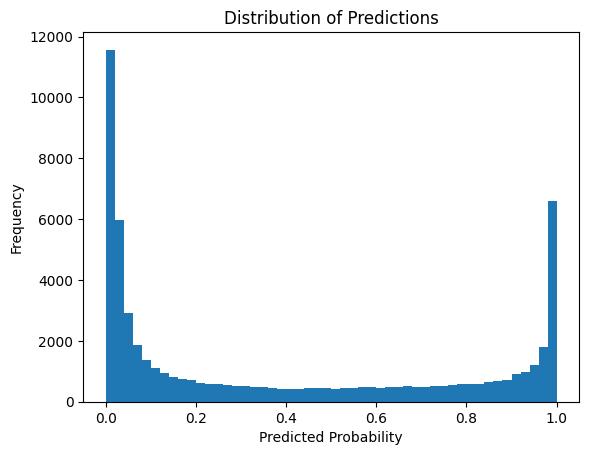

                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.685537
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.051366
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.125099
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.293319
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.418326


In [12]:
# List all test image filenames
test_filenames = os.listdir(test_dir)
print(f"Total test images: {len(test_filenames)}")

# Create a DataFrame for test data
test_df = pd.DataFrame({'filename': test_filenames})

# Create a Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  # No labels
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False  # Keep data in order
)

# Use the Trained Model to Predict Probabilities
predictions = advanced_model.predict(test_generator, verbose=1)

# Prepare the Submission DataFrame
# Remove the '.tif' extension from filenames to match the required 'id' format
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)
test_df['label'] = predictions  # Predictions are probabilities

# Create the submission DataFrame
submission = test_df[['id', 'label']]

# Clip predictions to [0,1]
submission['label'] = submission['label'].clip(0, 1)

# Plot the Distribution of Predictions
plt.hist(submission['label'], bins=50)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Save the Submission File
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(submission.head())

Conclusion
Summary of Findings

- Model Performance: The advanced CNN model outperformed the baseline model in validation accuracy.
- Data Augmentation: Helped mitigate overfitting and improved generalization.
- Hyperparameters: Proper tuning of learning rate and batch size enhanced model performance.

Future Work

- Transfer Learning: Utilize pre-trained models like VGG16 or ResNet50 for potentially better performance.
- Ensemble Methods: Combine predictions from multiple models to improve accuracy.
- Hyperparameter Optimization: Implement grid search or Bayesian optimization for more systematic tuning.

Learnings and Takeaways

- Importance of Data Augmentation: Crucial for improving model generalization on limited datasets.
- Model Complexity: A deeper network isn't always better; balancing depth and regularization is key.
- Continuous Evaluation: Regularly validating the model during training helps in preventing overfitting.